This file works primarily to query information about fume hood usage on campus. Calculating fume hood energy usage can be roughly simplified by the following formula:

BTU/hr = 1.08 * CFM * (Th-Tl)

CFM represents the cubic feet per minute of air passing through a fume hood. Th is the temperature of the room, Tl is the temperature of outdoors. We will update this script for fume hood energy usage during periods of cooling later.

In [1]:
import pandas as pd
import numpy as np
# import datetime
from datetime import datetime, timezone
import requests
import json
import matplotlib.pyplot as plt
import math
import scipy.stats as st

In [2]:
def create_tuple(response):
    # all data
    response_data = response.json()
    # print(response_data)
    # data for a single target
    response_datum = response_data[0]
    # print(response_datum)
    # the target - e.g. "120MapleAve.STM.M22-V/AverageMassFlow"
    response_target = response_datum['target']
    # the metric for this target - e.g. "Steam"
    #response_metric = response_datum['metric']
    # print(response_metric)
    # the datapoints as a list of lists
    response_datapoints = response_datum['datapoints']
    # print(response_datapoints)
    # array of tuples for numpy
    tuple_array = [tuple(x) for x in response_datapoints]
    # make a numpy array
    npa = np.array(tuple_array, dtype=[
                   ('value', np.double), ('ts', 'datetime64[ms]')])
    # npa = npa.astype([('value', np.double), ('ts', datetime)])

    # print("here")
    # for index, i in enumerate(npa):
    #   j = pd.to_datetime(i[1]).replace(tzinfo=timezone.utc).astimezone(tz="America/New_York")
    #   npa[index][1] = j
    return npa

In [89]:
def current_date():
    return str(datetime.now())

In [113]:
"""
Returns an array of tuples where tuple[0] is the metric, and tuple[1] is the time 
of measurement

Target: a WebCTRL point name in the form of a string 
Example: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log"

Server: a string representing the WebCTRL server our point exists in
Example: "biotech_main"

Start: the start time we wish to be querying data about (in string format)
Example: "2021-12-31T11:00Z"

End: The end time we wish to be querying data about
Example: "2022-12-31T11:00Z"
"""
def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server
          },
          "target": target
        }
      ],

    }
  request = requests.post(url, json=data)
  print(request)
  return create_tuple(request)

fume_query(target="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", server="biotech_main", start="2021-12-25T00:00:00.000", end=current_date())
# fume_query(target="#lstb_b-07_north/fh_sash_pos", server="weill_main", start="2022-10-22T11:00Z", end="2022-10-22T11:05Z")
# fume_query(target="#baker_west_lab_120/fh_sash_pos", server="endowed_main", start="2022-10-10T11:00Z", end="2022-10-22T11:05Z")

<Response [200]>


array([(3.5, '2021-12-25T05:00:00.000'), (3.5, '2021-12-25T05:05:00.000'),
       (3.5, '2021-12-25T05:10:00.000'), ...,
       (1.1, '2022-12-27T18:10:00.000'), (1.1, '2022-12-27T18:15:00.000'),
       (1.1, '2022-12-27T18:20:00.000')],
      dtype=[('value', '<f8'), ('ts', '<M8[ms]')])

In [114]:
"""
Returns a time series of the ithaca air temperature over the respective 
"""

def outside_temp(start,end):
  # https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query
  url = "https://portal-api.emcs.cucloud.net/query"
  target = "GameFarmRoadWeatherStation.TAVG_H_F"
  data = {
    "range": {
        "from": start,
        "to": end
    },
    "targets": [
        {
            "payload": {
                "additional": [
                    "metric",
                    "unit",
                    "nolimit",
                    "noagg"
                ]
            },
            "target": target,
            "type": "timeseries"
        }
    ]
  }
  request = requests.post(url, json=data)
#   print(request)
  return create_tuple(request)

In [115]:
from dateutil import rrule
 
# dates
start_date = datetime(2019, 11, 17)
end_date = datetime(2022, 12, 27)
# end_date = datetime(2020, 2, 27)

months = rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date)

master_series = pd.Series(data=None)
 
for index, val in enumerate(months):
    if(index<(len(list(months))-1)):
        print(str(months[index]))
        external_temp_master = outside_temp(start=str(months[index]), end=str(months[index+1]))
        tmp_series = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
        master_series = pd.concat([master_series, tmp_series])

master_series = master_series[master_series > -100] # prevent ridiculosuly low temps
master_series[~master_series.index.duplicated()].to_csv("C:/Users/Dan/Documents/GitHub/fume-hood-dashboard/game_farm/hist.csv", header=False)

C:\Users\Dan\AppData\Local\Temp\ipykernel_15112\3393769608.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  master_series = pd.Series(data=None)


2019-11-17 00:00:00
2019-12-17 00:00:00
2020-01-17 00:00:00
2020-02-17 00:00:00
2020-03-17 00:00:00
2020-04-17 00:00:00
2020-05-17 00:00:00
2020-06-17 00:00:00
2020-07-17 00:00:00
2020-08-17 00:00:00
2020-09-17 00:00:00
2020-10-17 00:00:00
2020-11-17 00:00:00
2020-12-17 00:00:00
2021-01-17 00:00:00
2021-02-17 00:00:00
2021-03-17 00:00:00
2021-04-17 00:00:00
2021-05-17 00:00:00
2021-06-17 00:00:00
2021-07-17 00:00:00
2021-08-17 00:00:00
2021-09-17 00:00:00
2021-10-17 00:00:00
2021-11-17 00:00:00
2021-12-17 00:00:00
2022-01-17 00:00:00
2022-02-17 00:00:00
2022-03-17 00:00:00
2022-04-17 00:00:00
2022-05-17 00:00:00
2022-06-17 00:00:00
2022-07-17 00:00:00
2022-08-17 00:00:00
2022-09-17 00:00:00
2022-10-17 00:00:00
2022-11-17 00:00:00


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
CFM List:  2021-11-17 05:00:00    224.62
2021-11-17 05:05:00    223.15
2021-11-17 05:10:00    224.13
2021-11-17 05:15:00    224.13
2021-11-17 05:20:00    224.62
                        ...  
2022-11-18 04:35:00    224.13
2022-11-18 04:40:00    223.64
2022-11-18 04:45:00    222.17
2022-11-18 04:50:00    223.15
2022-11-18 04:55:00    223.64
Length: 105395, dtype: float64
CFM List new:  2021-11-17 05:00:00    224.62
2021-11-17 05:05:00    223.15
2021-11-17 05:10:00    224.13
2021-11-17 05:15:00    224.13
2021-11-17 05:20:00    224.62
                        ...  
2022-11-18 04:35:00    224.13
2022-11-18 04:40:00    223.64
2022-11-18 04:45:00    222.17
2022-11-18 04:50:00    223.15
2022-11-18 04:55:00    223.64
Length: 105394, dtype: float64

Sash List:  2021-11-17 05:00:00    3.3
2021-11-17 05:05:00    3.3
2021-11-17 05:10:00    3.3
2021-11-17 05:15:00    3.3
2021-11-17 05:20:00    3.3
                      ... 
2022-11-1

,cfm,sash,occ,internal temp,external temp
2019-11-17 01:00:00,NaN,NaN,NaN,NaN,24.4706
2019-11-17 02:00:00,NaN,NaN,NaN,NaN,23.4842
2019-11-17 03:00:00,NaN,NaN,NaN,NaN,21.8570
2019-11-17 04:00:00,NaN,NaN,NaN,NaN,19.8572
2019-11-17 06:00:00,NaN,NaN,NaN,NaN,17.9492
...,...,...,...,...,...
2022-12-16 20:00:00,NaN,NaN,NaN,NaN,35.9906
2022-12-16 21:00:00,NaN,NaN,NaN,NaN,35.3174
2022-12-16 22:00:00,NaN,NaN,NaN,NaN,35.0816
2022-12-16 23:00:00,NaN,NaN,NaN,NaN,34.7810


,cfm,sash,occ,internal temp,external temp
2021-11-17 05:00:00,224.62,3.3,1.0,72.2,28.2452
2021-11-17 06:00:00,226.08,3.3,1.0,72.1,28.2560
2021-11-17 07:00:00,223.64,3.3,0.0,72.2,27.7160
2021-11-17 08:00:00,221.69,3.3,1.0,71.4,28.0292
2021-11-17 09:00:00,222.17,3.3,1.0,71.9,29.1110
...,...,...,...,...,...
2022-11-18 00:00:00,225.59,1.4,1.0,72.1,32.4374
2022-11-18 01:00:00,225.10,2.3,1.0,71.7,32.1314
2022-11-18 02:00:00,223.15,2.3,1.0,71.7,30.8354
2022-11-18 03:00:00,223.15,2.2,0.0,71.2,30.6338


,cfm,sash,occ,internal temp,external temp,BTUh
2021-11-17 05:00:00,224.62,3.3,1.0,72.2,28.2452,10662.977350
2021-11-17 06:00:00,226.08,3.3,1.0,72.1,28.2560,10705.231642
2021-11-17 07:00:00,223.64,3.3,0.0,72.2,27.7160,10744.273901
2021-11-17 08:00:00,221.69,3.3,1.0,71.4,28.0292,10384.062464
2021-11-17 09:00:00,222.17,3.3,1.0,71.9,29.1110,10266.946700
...,...,...,...,...,...,...
2022-11-18 00:00:00,225.59,1.4,1.0,72.1,32.4374,9663.284809
2022-11-18 01:00:00,225.10,2.3,1.0,71.7,32.1314,9619.443209
2022-11-18 02:00:00,223.15,2.3,1.0,71.7,30.8354,9848.450329
2022-11-18 03:00:00,223.15,2.2,0.0,71.2,30.6338,9776.535332


Total BTUh:  45100057.59942696
Total BTUh occupied:  21572494.44563664
Total BTUh unoccupied:  23527563.15379032
Percent occupied:  0.5144406459978781


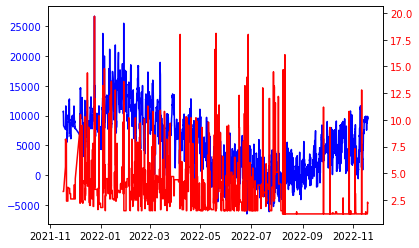

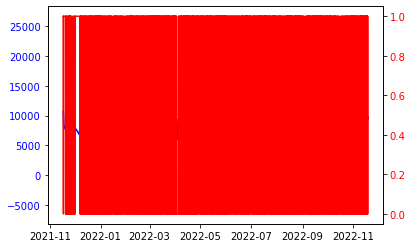

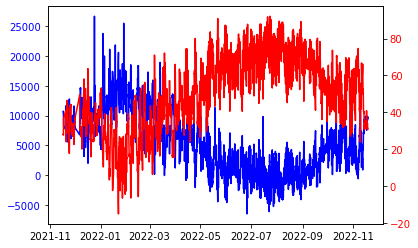

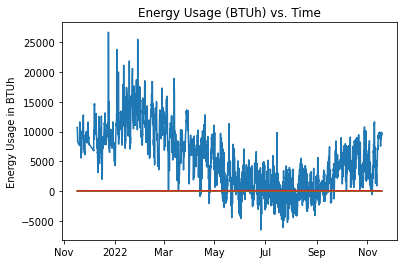

,cfm,sash,occ,internal temp,external temp,BTUh
2021-12-24 16:00:00,621.11,19.7,1.0,71.5,31.6832,26709.061660
2021-12-24 17:00:00,626.48,19.7,1.0,71.7,33.0440,26154.587750
2022-01-03 18:00:00,411.15,13.2,1.0,71.5,17.8682,23814.771736
2022-01-05 16:00:00,466.32,14.8,1.0,71.6,31.8596,20014.282794
2022-01-11 23:00:00,299.81,9.7,1.0,71.3,6.6020,20948.875970
2022-01-12 00:00:00,297.86,9.7,1.0,71.0,5.2340,21156.185621
2022-01-12 02:00:00,301.77,9.7,1.0,70.7,7.9160,20462.033894
2022-01-18 18:00:00,407.24,12.8,1.0,71.2,21.4646,21874.583840
2022-01-18 19:00:00,398.94,12.7,1.0,71.4,21.5618,21473.047629
2022-01-22 10:00:00,224.62,3.4,0.0,69.2,-13.3600,20028.197376


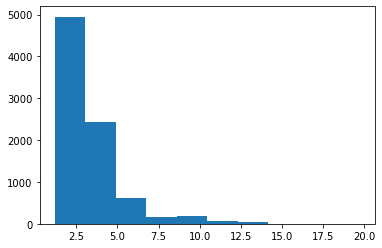

,cfm,sash,occ,internal temp,external temp,BTUh
2021-11-21 01:00:00,227.55,2.4,0.0,71.7,38.2046,8231.628532
2021-11-21 02:00:00,223.64,2.4,0.0,70.7,37.9418,7912.127356
2021-11-21 03:00:00,227.55,2.4,0.0,70.4,37.6682,8043.970777
2021-11-21 04:00:00,223.15,2.4,0.0,70.3,37.7042,7855.652992
2021-11-21 05:00:00,225.59,2.4,0.0,70.1,37.9994,7820.900302
...,...,...,...,...,...,...
2022-11-17 10:00:00,220.71,1.2,0.0,70.4,33.4256,8813.469410
2022-11-17 12:00:00,222.17,1.2,0.0,71.2,32.4500,9297.814500
2022-11-17 22:00:00,224.62,1.4,0.0,72.0,33.0026,9460.363667
2022-11-18 03:00:00,223.15,2.2,0.0,71.2,30.6338,9776.535332


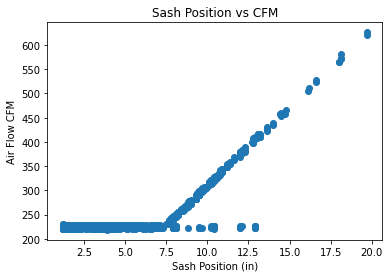

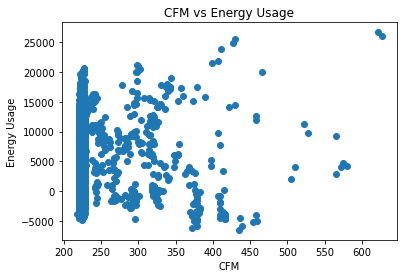

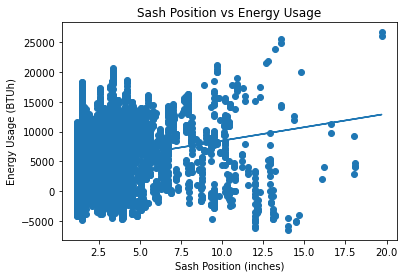

(0.20831321227116922, 8.237947155058967e-84)


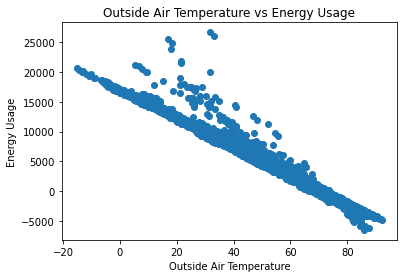

Variable: cfm(0.029855796067130177, 0.005959122558087342)
Variable: sash(0.20831321227116922, 8.237947155058967e-84)
Variable: occ(-0.07961096183338921, 2.0885766666294513e-13)
Variable: internal temp(-0.07607199726525775, 2.2894927603822275e-12)
Variable: external temp(-0.9888681727450792, 0.0)
Variable: BTUh(1.0, 0.0)


In [123]:
from datetime import datetime
from dateutil import parser
import matplotlib.dates as mdates
"""
Requires:
target_list: A python list filled with target strings
len(target_list) = 3 
target_list[0] should represent the CFM target
target_list[1] should represent the internal air setpoint target
target_list[2] should represent the occupancy target
target_list[3] should represent the sash position 

server: the server where the target is stored (string)
start: start_time (string)
end: end_time (string)

Returns: Energy Usage by fumehood in btus over set target period
"""

def query(target_list, server, start, end):
  cfm_master = fume_query(target_list[0],server,start,end)
  sash_master = fume_query(target_list[3],server,start,end)
  occ_master = fume_query(target_list[2],server,start,end)
  internal_temp_master = fume_query(target_list[1],server,start,end)
  # external_temp_master = outside_temp(start,end)

  cfm_list = pd.Series(data=[i[0] for i in cfm_master], index=[i[1] for i in cfm_master])
  print("CFM List: ", cfm_list)
  cfm_list = cfm_list[~cfm_list.index.duplicated()]
  print("CFM List new: ", cfm_list)

  sash_list = pd.Series(data=[i[0] for i in sash_master], index=[i[1] for i in sash_master])
  print("\nSash List: ", sash_list)
  sash_list = sash_list[~sash_list.index.duplicated()]
  print("\nSash List new: ", sash_list)

  occ_list = pd.Series(data=[i[0] for i in occ_master], index=[i[1] for i in occ_master])
  print("\nOCC List: ", occ_list)
  occ_list = occ_list[~occ_list.index.duplicated()]
  print("\nOCC List new: ", occ_list)
  
  internal_temp_list = pd.Series(data=[i[0] for i in internal_temp_master], index=[i[1] for i in internal_temp_master])
  print("\nInternal Temp List: ", internal_temp_list)
  internal_temp_list = internal_temp_list[~internal_temp_list.index.duplicated()]
  print("\nInternal Temp List new: ", internal_temp_list)

  # external_temp_list = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
  # print("\nExternal Temp List: ", external_temp_list)
  external_temp_list = pd.read_csv("C:/Users/Dan/Documents/GitHub/fume-hood-dashboard/game_farm/hist.csv", index_col=0).squeeze()
  external_temp_list.index = external_temp_list.index.astype('datetime64[ns]')
  print("\nExternal Temp List: ", external_temp_list)

  df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
  df.columns = ["cfm", "sash" ,"occ", "internal temp", "external temp"]
  display(df)

  df = df.dropna()
  display(df)

  df["BTUh"] = 1.08 * df["cfm"] * (df["internal temp"] - df["external temp"])

  display(df)
  
  # convert_dates = np.vectorize(lambda s: parser.parse(s))
  # convert_dates(external_temp_list)

  # external_temp_list_resampled = pd.Series(data=external_temp_list, index=external_temp_list_dates).resample("5T").asfreq()
  # print(external_temp_list_resampled)

  # yourdate = parser.parse([i[1] for i in cfmMaster][0].astype(str))

  #We should try to do this in 10 minute intervals...not exactly sure how tho

  print("Total BTUh: ", df["BTUh"].sum())
  print("Total BTUh occupied: ", df["BTUh"][df["occ"] == 1.0].sum())
  print("Total BTUh unoccupied: ", df["BTUh"][df["occ"] == 0].sum())
  print("Percent occupied: ", len(df[df["occ"] == 1.0]) / len(df))

  fig, ax = plt.subplots()
  ax.plot(df["BTUh"], color="blue")
  ax.tick_params(axis="y", labelcolor="blue")
  ax2 = ax.twinx()
  ax2.plot(df["sash"], color="red")
  ax2.tick_params(axis="y", labelcolor="red")
  plt.show()

  fig, ax = plt.subplots()
  ax.plot(df["BTUh"], color="blue")
  ax.tick_params(axis="y", labelcolor="blue")
  ax2 = ax.twinx()
  ax2.plot(df["occ"], color="red")
  ax2.tick_params(axis="y", labelcolor="red")
  plt.show()

  fig, ax = plt.subplots()
  ax.plot(df["BTUh"], color="blue")
  ax.tick_params(axis="y", labelcolor="blue")
  ax2 = ax.twinx()
  ax2.plot(df["external temp"], color="red")
  ax2.tick_params(axis="y", labelcolor="red")
  plt.show()

  plt.plot(df["BTUh"], label="BTUh")
  plt.plot(df["sash"])
  plt.plot(df["occ"])
  plt.plot(df["external temp"])
  plt.ylabel("Energy Usage in BTUh")
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
  plt.title("Energy Usage (BTUh) vs. Time")
  plt.show()

  display(df[df["BTUh"]>20000])

  plt.hist(df["sash"])
  plt.show()

  display(df[(df["occ"] == 0) & (df["sash"] < 3)])

  plt.scatter(df["sash"], df["cfm"])
  plt.title("Sash Position vs CFM")
  plt.xlabel("Sash Position (in)")
  plt.ylabel("Air Flow CFM")
  plt.show()

  plt.scatter(df["cfm"],df["BTUh"])
  plt.title("CFM vs Energy Usage")
  plt.xlabel("CFM")
  plt.ylabel("Energy Usage")
  plt.show()

  plt.scatter(df["sash"],df["BTUh"])
  m, b = np.polyfit(df["sash"], df["BTUh"], 1)
  plt.plot(df["sash"], m*df["sash"] + b)
  plt.title("Sash Position vs Energy Usage")
  plt.xlabel("Sash Position (inches)")
  plt.ylabel("Energy Usage (BTUh)")
  plt.show()

  plt.scatter(df["external temp"],df["BTUh"])
  plt.title("Outside Air Temperature vs Energy Usage")
  plt.xlabel("Outside Air Temperature")
  plt.ylabel("Energy Usage")

  pearson_r = st.pearsonr(df["sash"],df["BTUh"])
  print(pearson_r)
  plt.show()
  ndf = (df[df["BTUh"]>12000])

  
  for val in df.columns :
    print("Variable: " + str(val) + str(st.pearsonr(df[val],df["BTUh"])))
  return


target_list = ["#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash"]
server = "biotech_main"
start = str(datetime(2021, 11, 17))
end = str(datetime(2022, 11, 17))

query(target_list,server,start,end)